# Note :  Executez la partie enrichissement avant la partie analyse

# Connection with the database

In [218]:
import psycopg2
import psycopg2.extras
import pandas as pd

In [219]:
DB_CONFIG = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'i8D22021&', # Assurez-vous que le mot de passe est correct
    'host': 'localhost',
    'port': '5432'
}

In [220]:

query = """
SELECT 
*
from
Performances
"""


In [221]:
conn = None
try:
    print("connecting to the database")
    conn = psycopg2.connect(**DB_CONFIG)
    print("connection established")

    print(f"\nquery excution")
    df = pd.read_sql_query(query, conn)
except Exception as e:
    print(f"\nError : {e}")

finally:
    if conn is not None:
        conn.close()
    print("\nConnexion to the database is closed")

connecting to the database
connection established

query excution


C:\Users\Wael\AppData\Local\Temp\ipykernel_8152\3611090636.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)



Connexion to the database is closed


In [222]:
df.head()

,song_id,date,streams,popularity
0,2,2024-04-29,2398.0,8.0
1,2,2024-04-30,2404.0,8.0
2,2,2024-05-01,2414.0,8.0
3,2,2024-05-02,2417.0,8.0
4,2,2024-05-03,2428.0,8.0


# Analyse

## Imports

In [267]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats



## Visualisation de la popularité en fonction de nombre des straems

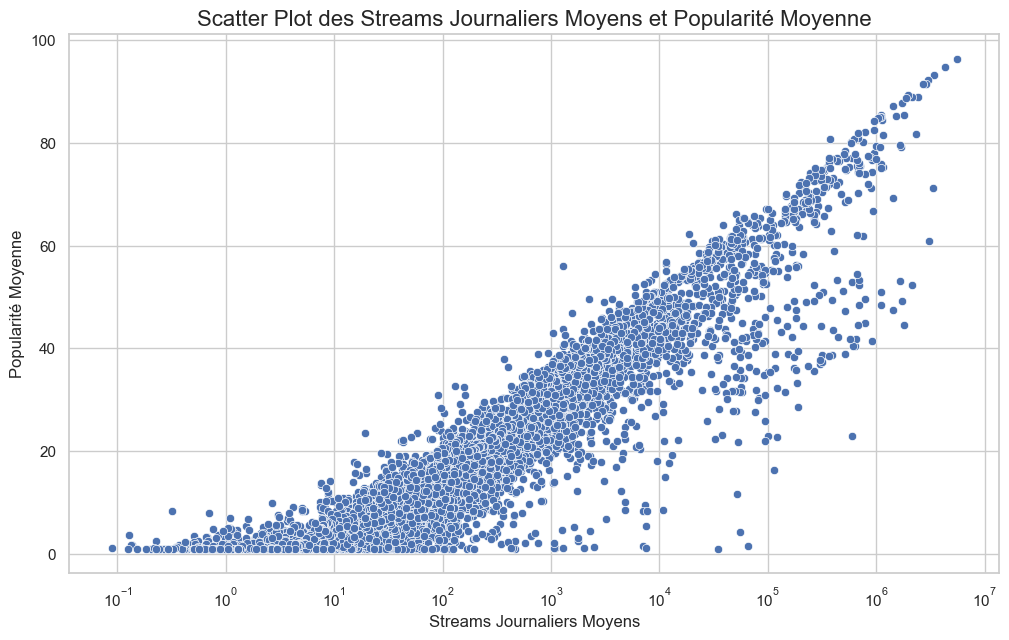

In [242]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))
    
sns.scatterplot(
        data=ex1,
        x='average_daily_streams',
        y='average_popularity',
    )
    
plt.title('Scatter Plot des Streams Journaliers Moyens et Popularité Moyenne', fontsize=16)
plt.xlabel('Streams Journaliers Moyens', fontsize=12)
plt.ylabel('Popularité Moyenne', fontsize=12)
    
plt.xscale('log')
    
plt.savefig('correlation_analysis_plot.png')
plt.show()

## Heatmap pour visualisé le coefficiant de correlation de pearson

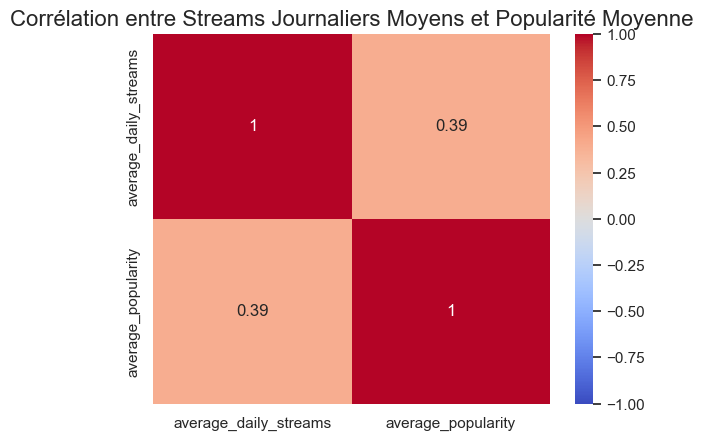

In [243]:
correlation_matrix = ex1[['average_daily_streams', 'average_popularity']].corr()
correlation_value = correlation_matrix.loc['average_daily_streams', 'average_popularity']
sns.set_theme(style="whitegrid")

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Corrélation entre Streams Journaliers Moyens et Popularité Moyenne', fontsize=16)

plt.show()

## Visualisation de la distribution des chansons en fonction des streams

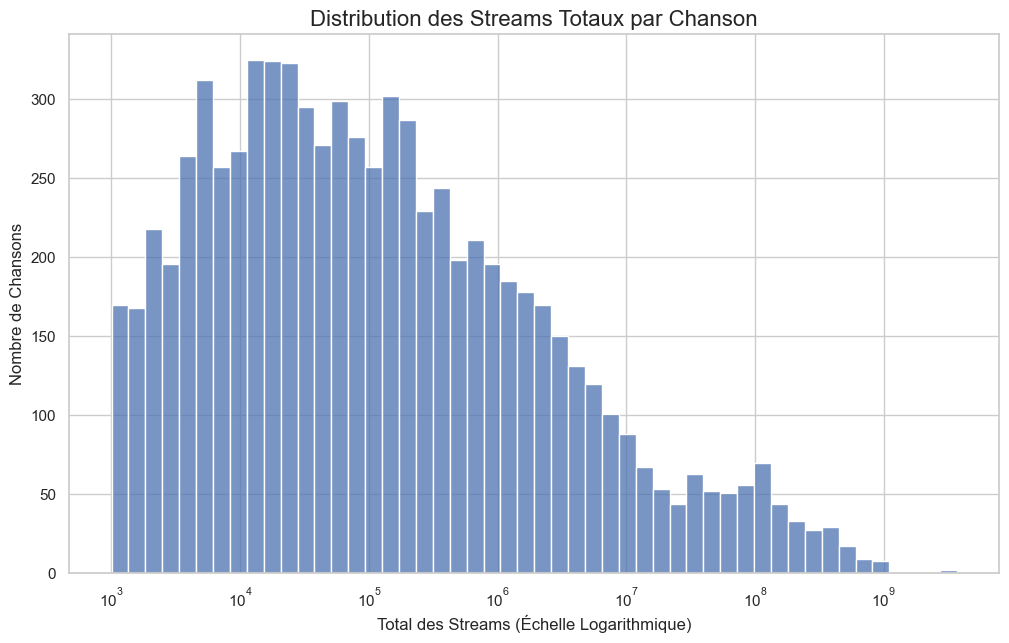

In [244]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.histplot(
    data=ex1,
    x='total_streams',
    bins=50, # Nombre de barres dans le graphique
    log_scale=True 
)

plt.title('Distribution des Streams Totaux par Chanson', fontsize=16)
plt.xlabel('Total des Streams (Échelle Logarithmique)', fontsize=12)
plt.ylabel('Nombre de Chansons', fontsize=12)

plt.savefig('streams_distribution.png')

plt.show()
        

## Test de P value pour assurer la correlation entre la popularité et le nombre des streams

In [245]:
correlation, p_value = stats.pearsonr(
    ex1['average_daily_streams'],
    ex1['average_popularity']
)

print(f"P-value : {p_value}")

P-value : 8.141510195003315e-280


## Clustring pour voir les segmentations des chansons

C:\Users\Wael\AppData\Local\Temp\ipykernel_8152\4276526093.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


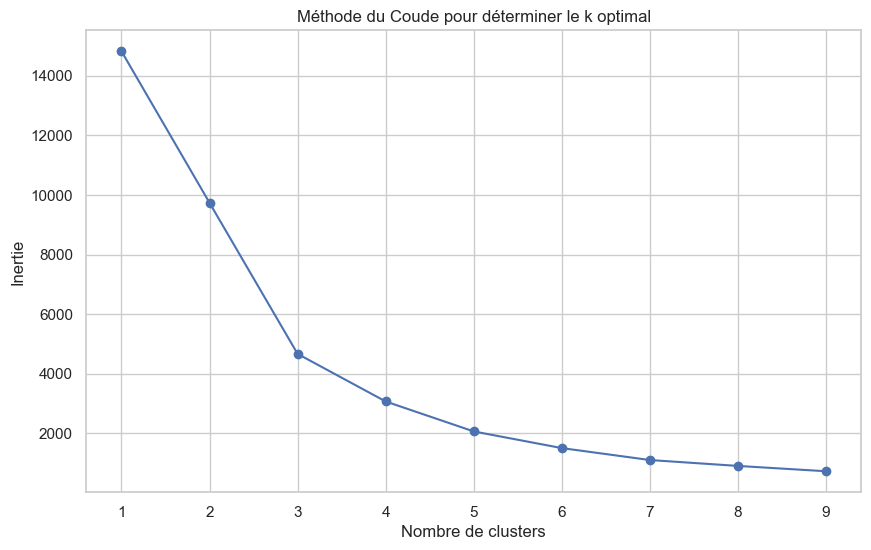

In [246]:
query = """
SELECT
    s.Song_ID,
    s.Title,
    (MAX(p.Streams) - MIN(p.Streams))::numeric / (MAX(p.Date) - MIN(p.Date) + 1) AS avg_daily_streams,
    AVG(p.Popularity) AS avg_popularity
FROM Songs s
JOIN Performances p ON s.Song_ID = p.Song_ID
WHERE p.Streams IS NOT NULL AND p.Popularity IS NOT NULL
GROUP BY s.Song_ID, s.Title
HAVING MAX(p.Date) > MIN(p.Date) AND COUNT(p.Date) > 30;
"""

conn = None
try:
    conn = psycopg2.connect(**DB_CONFIG)
    df = pd.read_sql_query(query, conn)
    df.dropna(inplace=True)

    features = df[['avg_daily_streams', 'avg_popularity']]
    
    # On met les données à l'échelle pour que les deux variables car la différence de scale est importante
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    inertia = []
    k_range = range(1, 10)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(features_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o')
    plt.title('Méthode du Coude pour déterminer le k optimal')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertie')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()
    
except Exception as e:
    print(f"Une erreur est survenue : {e}")
finally:
    if conn:
        conn.close()

* On peut voir que la valeur optimal de k est 3

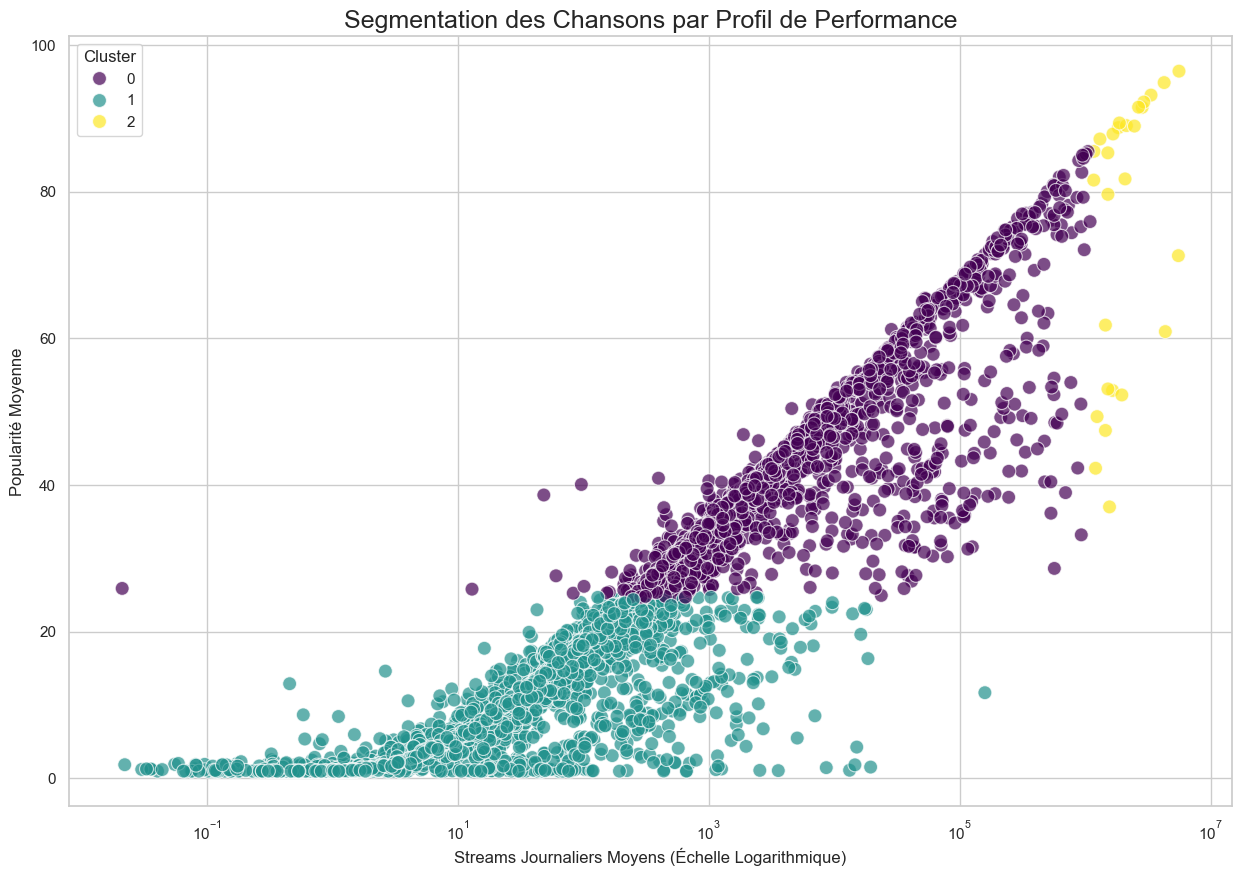


Analyse des caractéristiques de chaque cluster
         avg_daily_streams  avg_popularity
cluster                                   
2             2.306341e+06       75.300924
0             3.860751e+04       40.232396
1             1.563999e+02        8.812124


In [247]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')

df['cluster'] = kmeans.fit_predict(features_scaled)

# Visualisation des clusters

plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=df,
    x='avg_daily_streams',
    y='avg_popularity',
    hue='cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.xscale('log')
plt.title('Segmentation des Chansons par Profil de Performance', fontsize=18)
plt.xlabel('Streams Journaliers Moyens (Échelle Logarithmique)', fontsize=12)
plt.ylabel('Popularité Moyenne', fontsize=12)
plt.legend(title='Cluster')
plt.show()

print("\nAnalyse des caractéristiques de chaque cluster")
cluster_analysis = df.groupby('cluster')[['avg_daily_streams', 'avg_popularity']].mean().sort_values(by='avg_daily_streams', ascending=False)
print(cluster_analysis)

## Visualisation de l'evolution temporelle de la popularité d'une chanson

In [248]:
def plot_popularity_evolution(song_id: str):
    """
    Args:
        song_id (str): L'identifiant de la chanson à analyser.
    """
    
    query = """
        SELECT
            Date,
            Popularity
        FROM
            Performances
        WHERE
            Song_ID = %(song_id)s
            AND Popularity IS NOT NULL
        ORDER BY
            Date ASC;
    """
    params = {'song_id': song_id}
    
    conn = None
    try:
        conn = psycopg2.connect(**DB_CONFIG)

        df = pd.read_sql_query(query, conn, params=params, parse_dates=['date'])

        if df.empty:
            return


        sns.set_theme(style="whitegrid")
        plt.figure(figsize=(15, 8))

        lineplot = sns.lineplot(
            data=df,
            x='date',
            y='popularity',
        )
        
        plt.title(f'Évolution de la Popularité pour la Chanson {song_id[:8]}...', fontsize=18)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Score de Popularité (0-100)', fontsize=12)
        
        
        plt.tight_layout() 

        plt.show()

    except Exception as e:
        print(f"\nError : {e}")

    finally:
        if conn:
            conn.close()


#### test

C:\Users\Wael\AppData\Local\Temp\ipykernel_8152\4107262030.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params, parse_dates=['date'])


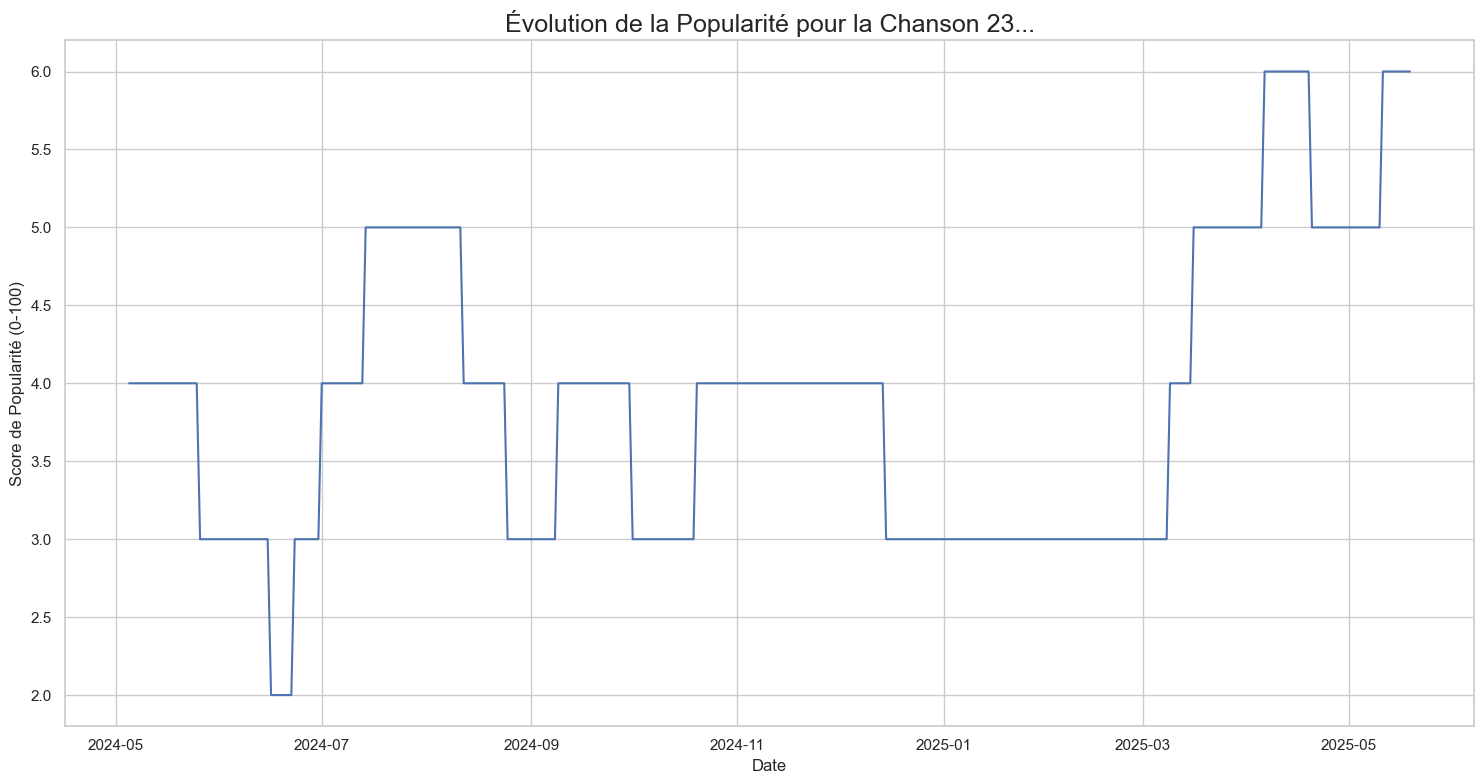

In [251]:
plot_popularity_evolution('23')

## Visualisation des nombre de streams et de popularité pour des saisons differentes

In [252]:
def analyze_performance_by_season():
    
    query = """
    WITH SongKPIs AS (
        -- Étape 1 : On calcule la vélocité moyenne pour chaque chanson
        SELECT
            s.Release_Date,
            (MAX(p.Streams) - MIN(p.Streams))::numeric / (MAX(p.Date) - MIN(p.Date) + 1) AS true_average_daily_streams
        FROM
            Songs s
        JOIN
            Performances p ON s.Song_ID = p.Song_ID
        WHERE
            p.Streams IS NOT NULL AND s.Release_Date IS NOT NULL
        GROUP BY
            s.Song_ID, s.Title, s.Release_Date
        HAVING
            MAX(p.Date) > MIN(p.Date)
    )
    -- Étape 2 : On assigne une saison à chaque chanson et on calcule la moyenne par saison
    SELECT
        -- On utilise CASE pour déterminer la saison en fonction du mois et du jour
        CASE 
            WHEN TO_CHAR(Release_Date, 'MM-DD') BETWEEN '03-20' AND '06-20' THEN 'Printemps'
            WHEN TO_CHAR(Release_Date, 'MM-DD') BETWEEN '06-21' AND '09-22' THEN 'Été'
            WHEN TO_CHAR(Release_Date, 'MM-DD') BETWEEN '09-23' AND '12-20' THEN 'Automne'
            ELSE 'Hiver'
        END AS release_season,
        AVG(true_average_daily_streams) AS avg_daily_streams_for_season
    FROM
        SongKPIs
    GROUP BY
        release_season
    ORDER BY
        avg_daily_streams_for_season DESC;
    """
    
    conn = None
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        df_season = pd.read_sql_query(query, conn)
        
        if df_season.empty:
            return None
            
        return df_season

    except Exception as e:
        print(f"Error : {e}")
        return None
    finally:
        if conn:
            conn.close()



In [253]:
df_results = analyze_performance_by_season()

C:\Users\Wael\AppData\Local\Temp\ipykernel_8152\3710643253.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_season = pd.read_sql_query(query, conn)


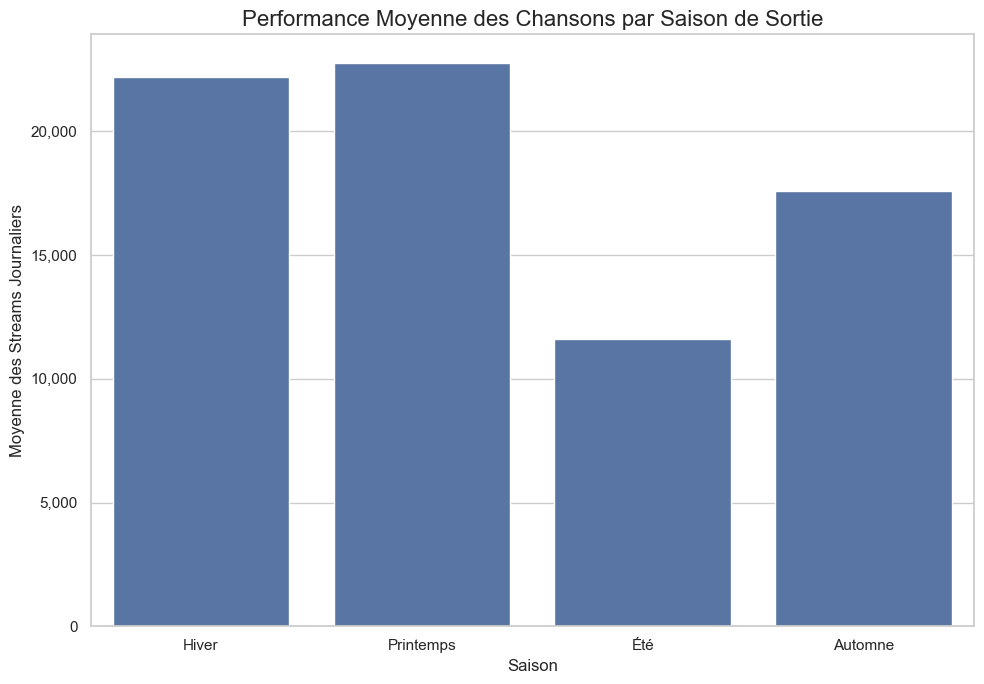

In [254]:
plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")
        
barplot = sns.barplot(
            data=df_results,
            x='release_season',
            y='avg_daily_streams_for_season',
            # On ordonne les barres pour une meilleure lecture
            order=['Hiver', 'Printemps', 'Été', 'Automne']
        )
        
plt.title('Performance Moyenne des Chansons par Saison de Sortie', fontsize=16)
plt.xlabel('Saison', fontsize=12)
plt.ylabel('Moyenne des Streams Journaliers', fontsize=12)
        
barplot.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        
plt.tight_layout()
plt.show()

## Visualisation de la moyenne d'evolution d'une chanson pendant une periode apres la sortie en fonction des saisons

In [258]:
def analyze_initial_traction_by_season(days_after_release=1):
    """
    Analyse le nombre de streams accumulés après une période fixe (ex: 30 jours)
    en fonction de la saison de sortie de la chanson.

    Args:
        days_after_release (int): Le nombre de jours après la sortie pour mesurer l'impact.
    """

    query = """
    WITH StreamsAfterPeriod AS (
        -- Étape 1 : Pour chaque chanson, on trouve la valeur de streams la plus proche
        -- de la date cible (Release_Date + X jours).
        SELECT DISTINCT ON (s.Song_ID)
            s.Song_ID,
            s.Release_Date,
            p.Streams AS streams_after_period
        FROM
            Songs s
        JOIN
            Performances p ON s.Song_ID = p.Song_ID
        WHERE
            s.Release_Date IS NOT NULL
            -- On ne regarde que les performances qui ont lieu après la sortie
            -- et avant la fin de notre fenêtre de mesure.
            AND p.Date BETWEEN s.Release_Date AND (s.Release_Date + %(days)s)
        -- On garde la valeur la plus récente DANS cette fenêtre de 30 jours
        ORDER BY
            s.Song_ID, p.Date DESC
    )
    -- Étape 2 : On agrège ces valeurs par saison de sortie.
    SELECT
        CASE 
            WHEN TO_CHAR(Release_Date, 'MM-DD') BETWEEN '03-20' AND '06-20' THEN 'Printemps'
            WHEN TO_CHAR(Release_Date, 'MM-DD') BETWEEN '06-21' AND '09-22' THEN 'Été'
            WHEN TO_CHAR(Release_Date, 'MM-DD') BETWEEN '09-23' AND '12-20' THEN 'Automne'
            ELSE 'Hiver'
        END AS release_season,
        AVG(sap.streams_after_period) AS avg_streams_after_period
    FROM
        StreamsAfterPeriod sap
    GROUP BY
        release_season
    ORDER BY
        release_season;
    """
    
    params = {'days': days_after_release}
    conn = None
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        df_traction = pd.read_sql_query(query, conn, params=params)
        
        if df_traction.empty:
            print("Not enough data to perform the analysis.")
            return None
            
        return df_traction

    except Exception as e:
        print(f"Error : {e}")
        return None
    finally:
        if conn:
            conn.close()


In [263]:
df_results = analyze_initial_traction_by_season(days_after_release=1)

C:\Users\Wael\AppData\Local\Temp\ipykernel_8152\2325909914.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_traction = pd.read_sql_query(query, conn, params=params)


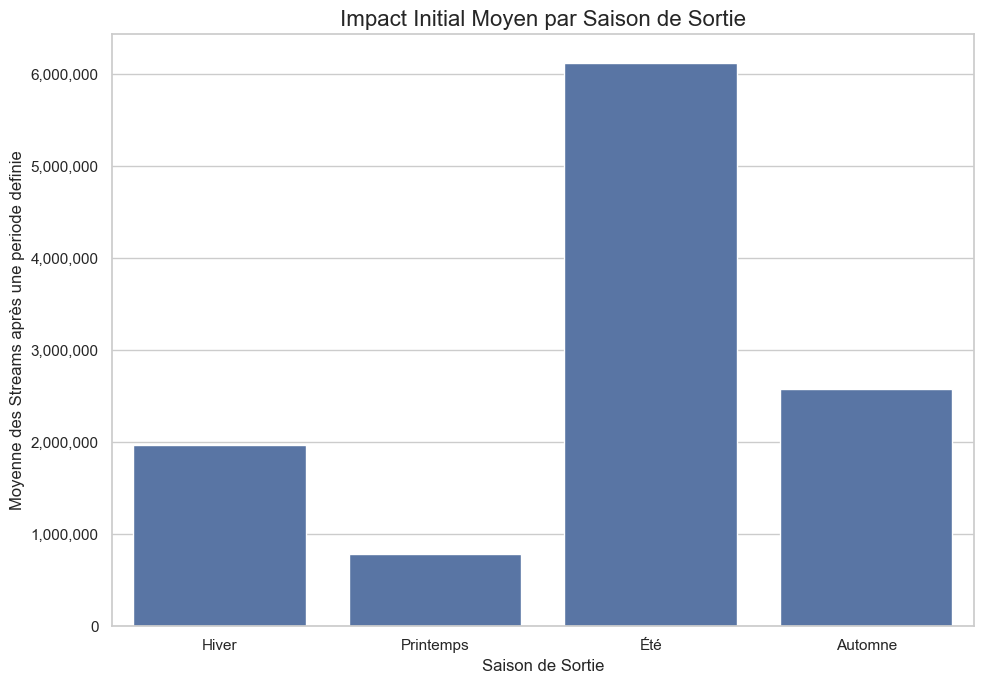

In [264]:
plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")
        
barplot = sns.barplot(
            data=df_results,
            x='release_season',
            y='avg_streams_after_period',
            order=['Hiver', 'Printemps', 'Été', 'Automne']
        )
        
plt.title('Impact Initial Moyen par Saison de Sortie', fontsize=16)
plt.xlabel('Saison de Sortie', fontsize=12)
plt.ylabel('Moyenne des Streams après une periode definie', fontsize=12)
        
barplot.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        
plt.tight_layout()
plt.show()

## Visualisation de l'impact de nombre des chanson sur la popularité d'un artist

In [269]:
def get_all_artists_stats():
    """
    Returns:
        pandas.DataFrame: Un DataFrame contenant les stats pour chaque artiste.
    """

    query = """
    SELECT
        a.Name AS artist_name,
        COUNT(DISTINCT s.Song_ID) AS number_of_songs,
        AVG(p.Popularity) AS average_popularity
    FROM
        Artists a
    JOIN
        Sing si ON a.Artist_ID = si.Artist_ID
    JOIN
        Songs s ON si.Song_ID = s.Song_ID
    JOIN
        Performances p ON s.Song_ID = p.Song_ID
    WHERE
        p.Popularity IS NOT NULL
    GROUP BY
        a.Artist_ID, a.Name
    HAVING
        COUNT(DISTINCT s.Song_ID) > 1
    ORDER BY
        number_of_songs DESC;
    """
    
    conn = None
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        df = pd.read_sql_query(query, conn)
        return df

    except Exception as e:
        print(f"Error : {e}")
        return None
    finally:
        if conn:
            conn.close()



In [271]:
df_artists = get_all_artists_stats()
df_artists.tail()

C:\Users\Wael\AppData\Local\Temp\ipykernel_8152\2429880386.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,artist_name,number_of_songs,average_popularity
1191,Marble Slave,2,9.298956
1192,Vianney,2,41.484268
1193,Bon Entendeur,2,45.903005
1194,L.E.J,2,41.240437
1195,Fabian Ordonez,2,22.994536



Résultats du test statistique :  
Coefficient de Corrélation: -0.0254
P-value: 0.3799249352324972
La corrélation n'est pas statistiquement significative.


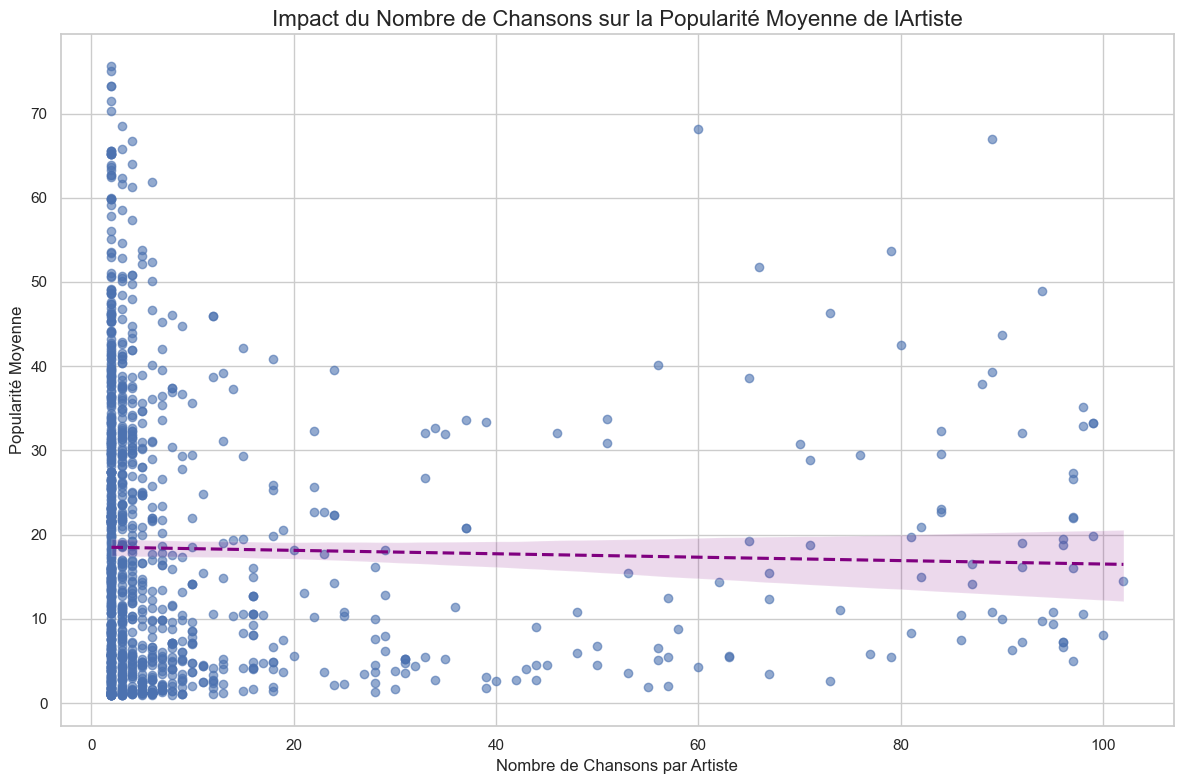

In [273]:
correlation, p_value = stats.pearsonr(
    df_artists['number_of_songs'],
    df_artists['average_popularity']
)
print("\nRésultats du test statistique :  ")
print(f"Coefficient de Corrélation: {correlation:.4f}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("La corrélation est statistiquement significative.")
else:
    print("La corrélation n'est pas statistiquement significative.")

# --- Visualisation ---
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

sns.regplot(
    data=df_artists,
    x='number_of_songs',
    y='average_popularity',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'purple', 'linestyle': '--'}
)

plt.title('Impact du Nombre de Chansons sur la Popularité Moyenne de lArtiste', fontsize=16)
plt.xlabel('Nombre de Chansons par Artiste', fontsize=12)
plt.ylabel('Popularité Moyenne', fontsize=12)

plt.tight_layout()
plt.show()

# Enrichissement

## Fonction pour calculer la moyenne des streams et popularité par jour

In [227]:
def all_songs_avrg_daily_streams() -> pd.DataFrame:
    """    
    Returns:
        pandas.DataFrame: Un DataFrame avec les KPIs pour chaque chanson.
    """
    
    query = """
        SELECT
            s.Title,
            s.Release_Date,
            MAX(p.Date) AS last_observation_date,
            MAX(p.Streams) AS total_streams,
            MAX(p.Streams)::numeric / (MAX(p.Date) - s.Release_Date + 1) AS average_daily_streams,
            AVG(p.Popularity) AS average_popularity
        FROM
            Songs s
        JOIN
            Performances p ON s.Song_ID = p.Song_ID
        WHERE
            p.Streams IS NOT NULL 
            AND p.Popularity IS NOT NULL
            AND s.Release_Date IS NOT NULL
        GROUP BY
            s.Song_ID, s.Title, s.Release_Date
        HAVING
            MAX(p.Date) > s.Release_Date
        ORDER BY total_streams DESC;
    """
    
    conn = None
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        df = pd.read_sql_query(query, conn)
        return df
    except Exception as e:
        print(f"Error : {e}")
        return None
    finally:
        if conn:
            conn.close()


#### test

In [228]:
ex1=all_songs_avrg_daily_streams()
ex1.tail()

C:\Users\Wael\AppData\Local\Temp\ipykernel_8152\1612030185.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,title,release_date,last_observation_date,total_streams,average_daily_streams,average_popularity
7634,Adieu les saisons,2023-04-14,2025-05-26,1010,1.304910,1.0
7635,C'est commercial,2007-03-20,2025-05-21,1010,0.152154,1.0
7636,"The Seasons, Op. 37a: No 7, July. Reaper's Song",2024-10-04,2025-05-24,1005,4.313305,1.0
7637,1+,2024-08-23,2025-05-14,1005,3.792453,1.0
7638,3008 bonus Track,2010-07-12,2025-05-24,1001,0.184312,1.0


## Fonction pour calculer la moyenne des treams et popularité par jour pour une chanson donnée

In [229]:
def song_avrg_daily_streams(song_id: str) -> pd.DataFrame:
    """    
    Args:
        song_id (str): L'identifiant de la chanson à analyser.
        
    Returns:
        pandas.DataFrame: Un DataFrame avec les KPIs pour une chanson choisie.
    """    
    query = """
        SELECT
            s.Title,
            s.Release_Date,
            MAX(p.Date) AS last_observation_date,
            MAX(p.Streams) AS total_streams,
            MAX(p.Streams)::numeric / (MAX(p.Date) - s.Release_Date + 1) AS average_daily_streams,
            AVG(p.Popularity) AS average_popularity
        FROM
            Songs s
        JOIN
            Performances p ON s.Song_ID = p.Song_ID
        WHERE
            p.Streams IS NOT NULL 
            AND s.Song_ID = %(song_id)s
            AND p.Popularity IS NOT NULL
            AND s.Release_Date IS NOT NULL
        GROUP BY
            s.Song_ID, s.Title, s.Release_Date
        HAVING
            MAX(p.Date) > s.Release_Date;
    """
    params = {'song_id': song_id}
    
    conn = None
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        df = pd.read_sql_query(query, conn, params=params)
        
        if df.empty:
            return {"Error": "No data found for this song id."}
            
        return df

    except Exception as e:
        return {"Error": str(e)}
    finally:
        if conn:
            conn.close()


#### test

In [232]:
ex2=song_avrg_daily_streams("2")
ex2

C:\Users\Wael\AppData\Local\Temp\ipykernel_8152\1406327034.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,title,release_date,last_observation_date,total_streams,average_daily_streams,average_popularity
0,Backtrack,2024-02-02,2025-05-19,3949,8.348837,2.893782


## Fonction pour recuperer les statistiques d'un artist

In [233]:
def get_artist_stats(artist_name: str) -> pd.DataFrame:
    """
    Args:
        artist_name (str): Le nom exact de l'artiste à analyser.

    Returns:
        pandas.DataFrame: Un DataFrame avec les KPIs pour l'artiste.
    """
    
    query = """
    WITH SongLatestStreams AS (
        -- Étape 1 : On trouve le dernier total de streams pour chaque chanson
        SELECT
            s.Song_ID,
            MAX(p.Streams) AS latest_streams
        FROM Songs s
        JOIN Performances p ON s.Song_ID = p.Song_ID
        WHERE p.Streams IS NOT NULL
        GROUP BY s.Song_ID
    )
    -- Étape 2 : On agrège ces totaux par chanson au niveau de l'artiste
    SELECT
        a.Name AS artist_name,
        SUM(sls.latest_streams) AS artist_total_streams,
        AVG(p.Popularity) AS artist_average_popularity,
        COUNT(DISTINCT s.Song_ID) AS number_of_songs,
        -- Moyenne des streams par chanson = Total des streams de l'artiste / Son nombre de chansons
        SUM(sls.latest_streams) / COUNT(DISTINCT s.Song_ID) AS average_streams_per_song
    FROM
        Artists a
    JOIN
        Sing si ON a.Artist_ID = si.Artist_ID
    JOIN
        Songs s ON si.Song_ID = s.Song_ID
    JOIN
        Performances p ON s.Song_ID = p.Song_ID
    JOIN
        SongLatestStreams sls ON s.Song_ID = sls.Song_ID
    WHERE
        a.Name = %(artist_name)s
        AND p.Popularity IS NOT NULL
    GROUP BY
        a.Artist_ID, a.Name;
    """
    params = {'artist_name': artist_name}
    
    conn = None
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        df = pd.read_sql_query(query, conn, params=params)
        
        if df.empty:
            print(f"No data found for the artist : {artist_name}")
            return None
            
        return df

    except Exception as e:
        print(f"Error : {e}")
        return None
    finally:
        if conn:
            conn.close()



#### test

In [234]:
ex3=get_artist_stats('Werenoi')

C:\Users\Wael\AppData\Local\Temp\ipykernel_8152\1812337831.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


In [235]:
ex3

,artist_name,artist_total_streams,artist_average_popularity,number_of_songs,average_streams_per_song
0,Werenoi,1.045031e+11,65.736041,3,3.483438e+10


## Fonction pour recuperer l'evolution des streams d'une chanson

In [236]:
def get_song_streams_evolution(song_id: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Args:
        song_id (str): L'identifiant de la chanson.
        start_date (str): La date de début de la période ('YYYY-MM-DD').
        end_date (str): La date de fin de la période ('YYYY-MM-DD').

    Returns:
        pandas.DataFrame: Un DataFrame d'une seule ligne contenant l'évolution, ou un DataFrame avec une colonne d'erreur.
    """
    query_streams_at_date = """
        SELECT Streams
        FROM Performances
        WHERE
            Song_ID = %(song_id)s
            AND Date <= %(target_date)s
            AND Streams IS NOT NULL
        ORDER BY
            Date DESC
        LIMIT 1;
    """

    conn = None
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        cur = conn.cursor()

        cur.execute(query_streams_at_date, {'song_id': song_id, 'target_date': start_date})
        start_result = cur.fetchone()
        if not start_result:
            return pd.DataFrame([{"Error": f"No streaming data found before or on the start date. ({start_date})"}])
        streams_at_start = start_result[0]

        cur.execute(query_streams_at_date, {'song_id': song_id, 'target_date': end_date})
        end_result = cur.fetchone()
        if not end_result:
            return pd.DataFrame([{"error": f"No streaming data found before or on the end date. ({end_date})"}])
        streams_at_end = end_result[0]
        
        absolute_evolution = streams_at_end - streams_at_start
        
        if streams_at_start > 0:
            percentage_evolution = (absolute_evolution / streams_at_start) * 100
        else:
            percentage_evolution = float('inf') if absolute_evolution > 0 else 0.0

        result = {
            "song_id": song_id,
            "period_analyzed": f"{start_date} -> {end_date}",
            "streams_at_start": streams_at_start,
            "streams_at_end": streams_at_end,
            "absolute_evolution": absolute_evolution,
            "percentage_evolution": f"{percentage_evolution:.2f}%"
        }
        
        return pd.DataFrame([result])

    except Exception as e:
        return pd.DataFrame([{"Error": str(e)}])
    finally:
        if conn:
            conn.close()


#### test

In [239]:
ex4=get_song_streams_evolution("9153", '2025-04-23', '2025-05-21')

In [240]:
ex4

,song_id,period_analyzed,streams_at_start,streams_at_end,absolute_evolution,percentage_evolution
0,9153,2025-04-23 -> 2025-05-21,6723900,15787998,9064098,134.80%


## Fonction pour voir les kpis des chansons

In [280]:
def get_all_songs_kpis():
    """
    Récupère un DataFrame avec les KPIs agrégés pour chaque chanson.
    """
    query = """
        SELECT
            s.Title,
            MAX(p.Streams) AS latest_total_streams,
            AVG(p.Popularity) AS average_popularity
        FROM Songs s
        JOIN Performances p ON s.Song_ID = p.Song_ID
        WHERE p.Streams IS NOT NULL AND p.Popularity IS NOT NULL
        GROUP BY s.Song_ID, s.Title
        HAVING COUNT(p.Date) > 1
        order by latest_total_streams desc;
    """
    conn = None
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        df = pd.read_sql_query(query, conn)
        return df
    finally:
        if conn:
            conn.close()


In [281]:
df_songs = get_all_songs_kpis()
df_songs.head()

C:\Users\Wael\AppData\Local\Temp\ipykernel_8152\1725469011.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,title,latest_total_streams,average_popularity
0,I Ain't Worried,3698960001,71.283163
1,La Bachata,3331828504,60.930591
2,I Ain't Worried,1987306821,44.652174
3,un x100to,1302509647,79.209719
4,Quiéreme Mientras Se Pueda,1100985312,52.904884


In [286]:

descriptive_stats = df_songs[['latest_total_streams', 'average_popularity']].describe()

print(descriptive_stats)

       latest_total_streams  average_popularity
count          7.714000e+03         7714.000000
mean           1.225922e+07           18.556915
std            8.561543e+07           17.501596
min            1.001000e+03            1.000000
25%            1.154500e+04            3.696133
50%            7.747250e+04           13.408212
75%            8.018038e+05           28.975940
max            3.698960e+09           96.439394


## Fonction pour voir les Top artists et leurs statistiques

In [282]:
def get_streams_per_artist():
    """
    Calcule le total des streams cumulés pour chaque artiste.
    """
    query = """
    WITH SongLatestStreams AS (
        SELECT s.Song_ID, MAX(p.Streams) AS latest_streams
        FROM Songs s
        JOIN Performances p ON s.Song_ID = p.Song_ID
        WHERE p.Streams IS NOT NULL
        GROUP BY s.Song_ID
    )
    SELECT
        a.Name AS artist_name,
        SUM(sls.latest_streams) AS artist_total_streams
    FROM Artists a
    JOIN Sing si ON a.Artist_ID = si.Artist_ID
    JOIN SongLatestStreams sls ON si.Song_ID = sls.Song_ID
    GROUP BY a.Artist_ID, a.Name
    ORDER BY artist_total_streams DESC;
    """
    conn = None
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        df = pd.read_sql_query(query, conn)
        return df
    finally:
        if conn:
            conn.close()


In [284]:
df_artists = get_streams_per_artist()
df_artists.head(10)

C:\Users\Wael\AppData\Local\Temp\ipykernel_8152\3030612142.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,artist_name,artist_total_streams
0,Taylor Swift,1.742743e+10
1,Bad Bunny,1.705948e+10
2,Tyler,1.090723e+10
3,Melanie Martinez,1.065404e+10
4,Manuel Turizo,1.018215e+10
5,The Creator,1.013906e+10
6,OneRepublic,8.690431e+09
7,Angèle,3.559717e+09
8,Ofenbach,2.598795e+09
9,Damso,2.356525e+09
